# Lecture 5 - Demo Notebook

We first load and clean the data.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, auc
from sklearn.utils import resample

DATA_DIR = "./../../data"

In [2]:
# Parse the aggregated student data frame.
# This data is from an EPFL Linear Algebra flipped classroom. df_lq is aggregated features for the last week of student performance.
# ts represents the students' time series features.

df_lq = pd.read_csv('{}/aggregated_extended_fc.csv'.format(DATA_DIR))
ts = pd.read_csv('{}/time_series_extended_fc.csv'.format(DATA_DIR))

In [3]:
def remove_inactive_students(df, ts):
    """
    Filter the students (removing the ones that are inactive) to proceed with analysis on students who have participated during the entire class.
    Inputs: df, ts
    Outputs: filtered df, ts
    """
    # Fill all NaNs with strings to make them easier to process
    df = df.fillna('NaN')
    
    # Find all users weeks with 0 clicks on weekends and 0 clicks on weekdays during the first few weeks of the semester
    df_first = ts[ts.week < 5]
    rows = np.where(np.logical_and(df_first.ch_total_clicks_weekend==0, df_first.ch_total_clicks_weekday==0).to_numpy())[0]
    df_zero = df_first.iloc[rows, :]
    dropusers = np.unique(df_zero.user)

    # Drop users with no activity
    ts = ts[~ts.user.isin(dropusers)]
    df = df[~df.user.isin(dropusers)]
    return df, ts

df_lq, ts = remove_inactive_students(df_lq, ts)

The `compute_scores` function computes the performance of classifiers with accuracy + AUC. We will use this evaluation function for all our experiments.

In [4]:
def compute_scores(clf, X_train, y_train, X_test, y_test, roundnum=3, report=False):
    """
    Train clf (binary classification) model on X_train and y_train, predict on X_test. Evaluate predictions against ground truth y_test.
    Inputs: clf, training set (X_train, y_train), test set (X_test, y_test)
    Inputs (optional): roundnum (number of digits for rounding metrics), report (print scores)
    Outputs: accuracy, AUC
    """
    # Fit the clf predictor (passed in as an argument)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate roc AUC score
    AUC = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    
    # Print classification results
    if report:
        print(classification_report(y_test, y_pred))

    return round(accuracy, roundnum), round(AUC, roundnum)

We compute the pass/fail label of the students in the dataframe to use for the experiments. We will use the aggregated dataframe (df_lq) for all our experiments. If students have a grade higher than or equal to 4, they have passed the class.

In [5]:
df_lq['passed'] = (df_lq.grade >= 4).astype(int)

## Model Assessment

In a next step, we are interested in evaluating the generalizability of our models. We will use a random forest model for all our evaluations. For our evaluations, we will investigate behavioral features only.

In [6]:
# Filter out demographic features
features = [x for x in df_lq.columns if x not in ['user', 'week', 'grade', 'gender', 'category', 'year', 'passed']]
print(features)

['ch_num_sessions', 'ch_time_in_prob_sum', 'ch_time_in_video_sum', 'ch_ratio_clicks_weekend_day', 'ch_total_clicks_weekend', 'ch_total_clicks_weekday', 'ch_time_sessions_mean', 'ch_time_sessions_std', 'bo_delay_lecture', 'bo_reg_peak_dayhour', 'bo_reg_periodicity_m1', 'ma_competency_strength', 'ma_competency_anti', 'ma_content_anti', 'ma_student_shape', 'ma_student_speed', 'mu_speed_playback_mean', 'mu_frequency_action_relative_video_pause', 'wa_num_subs', 'wa_num_subs_correct', 'wa_num_subs_avg', 'wa_num_subs_perc_correct', 'la_pause_dur_mean', 'la_seek_len_std', 'la_pause_dur_std', 'la_time_speeding_up_mean', 'la_time_speeding_up_std', 'la_weekly_prop_watched_mean', 'la_weekly_prop_interrupted_mean', 'la_weekly_prop_interrupted_std', 'la_weekly_prop_replayed_mean', 'la_weekly_prop_replayed_std', 'la_frequency_action_video_play']


In [7]:
# Only keep behavioral features in X.
X = df_lq[features]

# Our binary indicator variable is based on our evaluation criteria: pass/fail.
y = df_lq['passed']

### Train-Test Setting

We split the data in a train-test split (stratified by the outcome variable).

In [8]:
# The train-test split is 80:20 (as shown by the 0.2 test_size argument). 
# We choose a random_state to replicate the results in the same split every time we run this notebook.
# The stratify argument ensures a proportionate number of passes/fails are in the training set and the test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Let's initialize a RandomForestClassifier to make our model predictions.

clf = RandomForestClassifier(random_state=42)

In [10]:
# We can use our compute_scores function to evaluate the results of our train-test split classifier.

accuracy, AUC = compute_scores(clf, X_train, y_train, X_test, y_test)

print(f'Accuracy for train-test setting: {accuracy}')
print(f'AUC for train-test setting: {AUC}')

Accuracy for train-test setting: 0.723
AUC for train-test setting: 0.723


### Cross Validation

In [11]:
# Initialize a new Random Forest predictor for our cross-validation comparison.

clf = RandomForestClassifier(random_state=42)

In [13]:
# With the cross_validate function, the SciKit Learn library automatically uses stratification across folds with the "cv" argument. 
# In the background, it's using the StratifiedKFold function with 10 folds.
# We pass in our desired metrics ("accuracy", "roc_auc") for evaluation in the "scoring" argument.

scores = cross_validate(clf, X, y, cv=5, scoring=['accuracy', 'roc_auc'])

print(f'Mean accuracy with cross-validation: {scores["test_accuracy"].mean():.3f}')
print(f'Mean AUC with cross-validation: {scores["test_roc_auc"].mean():.3f}')

Mean accuracy with cross-validation: 0.654
Mean AUC with cross-validation: 0.674


### Bootstrapping

Next, we use bootstrapping to evaluate our model. For this evaluation method, we can only compute the accuracy, but not the AUC.

The ROC curve is defined as the False Positive Rate, FPR = FP / (TN + FP), vs the True Positive Rate, TPR = TP / (TP + FN). However, when we consider a set of data points all with the same label, one of those two rates is undefined. 

In the setting of leave-one-out bootstrapping, we can confirm that this happens when we consider the predictions for the data point $i$ of all predictors $b \in C^{-i}$. If the point $i$ had label 1, then all the predictions for it would be either TP or FN, with FPR being undefined, while if it had label 0 all the predictions would be either TN or FP, with FPR undefined. Therefore, we will only consider accuracy as metric for bootstrapping.

In [14]:
# It is important to sample with:
# (1) the same size as the initial df (df_size) 
# (2) with replacement (replace=True)
# for the bootstrap samples to be representative.
df_size = len(df_lq)
B = 100

# Generate B bootstrap samples of the dataset with replacement.
samples = [resample(X, y, replace=True, n_samples=df_size) for b in range(B)]

# Train a random forest classifier for each bootstrap set
clfs = [RandomForestClassifier(random_state=42).fit(X_b, y_b) for X_b, y_b in samples]

In [15]:
# Calculate the predictions for each bootstrap sample (b in range(B)).
# Compare predictions against the ground truth (y.loc[[user]]). 
# Take the mean of predictions for each student (over on the number of times they were predicted).
# Takes ~2 mins
accuracies = [np.mean([clfs[b].predict(X.loc[[user]]) == y.loc[[user]] for b in range(B) if user not in samples[b][0].index])
              for user in df_lq.index]

In [16]:
# Take the mean of predictions across all students.
bootstrap_err = np.mean(accuracies)
bootstrap_err

0.6777444800695837

In [17]:
# Calculate the training error for each bootstrapped model, then average across bootstraps.
training_err_bootstrap = [clfs[b].score(samples[b][0], samples[b][1]) for b in range(B)]
training_err = np.mean(training_err_bootstrap)
training_err

1.0

In [65]:
accuracy_632 = 0.632 * bootstrap_err + 0.368 * training_err
print(f'Mean accuracy with .632 leave-one-out bootstrapping: {accuracy_632:.3f}')

Mean accuracy with .632 leave-one-out bootstrapping: 0.745


## Model Selection

Of course, when training ML models, we want to tune their hyperparameters in order to optimize the performance. In order to tune the hyperparameters of a model, we need to do further splits of our data set. To do so, we can freely combine the approaches presented in the model assessment section. In the following, we present a few ideas.

### Example 1: Train-Test-Validation Split

In the first example we use a train-test setting to perform the outer split (model assessment) as well as the inner split (model selection). We hold out 20% of the data for testing and 10% of the data for validation (for hyperparameter tuning).

In [18]:
# Select the test set as 20% of the initial data set
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# Select the training set as 70% of the initial dataset
# Select the validation set at 10% of the initial dataset (we use 1/8 here because we've already split the set once)
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=1/8, random_state=42, stratify=y_1)

In [20]:
# We compute a grid search across the following parameter space
parameters = {
    'n_estimators': [20, 50, 100],
    'criterion': ['entropy', 'gini'],
    'max_depth': np.arange(3, 9),
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 3, 5],
}

params_grid = ParameterGrid(parameters)

In [21]:
# For each combination of candidate parameters, fit a classifier on the training set and evaluate it on the validation set
results = [[params, compute_scores(RandomForestClassifier(random_state=42, **params), 
                                   X_train, y_train, X_val, y_val)] for params in params_grid]

In [22]:
# Sort candidate parameters according to their accuracy
results = sorted(results, key=lambda x: x[1][0], reverse=True)

In [23]:
# Obtain the best parameters
best_params = results[0][0]
best_params

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [24]:
# Train and evaluate a model based on the best parameter settings
clf = RandomForestClassifier(random_state=42, **best_params)
accuracy, AUC = compute_scores(clf, X_1, y_1, X_test, y_test)

print(f'Accuracy for train-validation-test setting: {accuracy}')
print(f'AUC for train-validation-test setting: {AUC}')

Accuracy for train-validation-test setting: 0.681
AUC for train-validation-test setting: 0.739


### Example 2: Nested 10-Fold Cross Validation

We use a 10-fold cross validation to perform the outer split (model assessment) as well as the inner split (model selection), leading to a **nested** 10-fold cross validation.

In [25]:
# We compute a grid search across the following parameter space
parameters = {
    'n_estimators': [20, 50, 100],
    'criterion': ['entropy', 'gini'],
    'max_depth': np.arange(3, 7),
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}

In [26]:
# This cell takes ~3 minutes to run

# Inner cross validation loop
clf = GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=10)

# Outer cross validation loop
scores_nested_cv = cross_validate(clf, X, y, cv=3, scoring=['accuracy', 'roc_auc'])

In [27]:
print(f'Mean accuracy with nested cross-validation: {scores_nested_cv["test_accuracy"].mean():.3f}')
print(f'Mean AUC with nested cross-validation: {scores_nested_cv["test_roc_auc"].mean():.3f}')

Mean accuracy with nested cross-validation: 0.692
Mean AUC with nested cross-validation: 0.677


### Example 3: Cross Validation with Bootstrap

We perform cross validation on the bootstrap data set from before to tune the hyperparameters.

In [29]:
# We compute a grid search across the following parameter space
parameters = {
    'n_estimators': [20, 50],
    'criterion': ['gini'],
    'max_depth': np.arange(3, 5),
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}

In [30]:
df_size = len(df_lq)
B = 100

# Generate B samples with replacement
samples = [resample(X, y, replace=True, n_samples=df_size) for b in range(B)]
# Train a random forest classifier for each sample, cross-validating to find the best parameters
clfs = [GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=3).fit(X_b, y_b) for X_b, y_b in samples]

In [31]:
# Calculate the predictions for each bootstrap sample (b in range(B)).
# Compare predictions against the ground truth (y.loc[[user]]). 
# Take the mean of predictions for each student (over on the number of times they were predicted).
# Takes ~2 mins
accuracies_bootstrap = [np.mean([clfs[b].predict(X.loc[[user]]) == y.loc[[user]] for b in range(B) if user not in samples[b][0].index])
                        for user in df_lq.index]

In [32]:
# Take the mean of predictions across all students.
bootstrap_err = np.mean(accuracies_bootstrap)
bootstrap_err

0.6717061248044779

In [33]:
# Calculate the training error for each bootstrapped model, then average across bootstraps.
training_err_bootstrap = [clfs[b].score(samples[b][0], samples[b][1]) for b in range(B)]
training_err = np.mean(training_err_bootstrap)
training_err

0.9223931623931625

In [34]:
accuracy_632 = 0.632 * bootstrap_err + 0.368 * training_err
print(f'Mean accuracy with .632 leave-one-out bootstrapping: {accuracy_632:.3f}')

Mean accuracy with .632 leave-one-out bootstrapping: 0.764


### Example 4: Train-Test (Outer Loop) + 10-Fold Cross Validation (Inner Loop)

We perform a train-test outer split and use 10-fold cross validation on the inner split to tune the hyperparameters.

In [35]:
# Create outer loop with stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
# We compute a grid search across the following parameter space
parameters = {
    'n_estimators': [20, 50, 100],
    'criterion': ['entropy', 'gini'],
    'max_depth': np.arange(3, 7),
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}

In [37]:
# Train model on inner loop with grid-search 10-fold cross validation
clf = GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=10)
accuracy, AUC = compute_scores(clf, X_train, y_train, X_test, y_test)

In [38]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [39]:
print(f'Accuracy for train-test splitting + cross-validation: {accuracy:.3f}')
print(f'AUC for train-test splitting + cross-validation: {AUC:.3f}')

Accuracy for train-test splitting + cross-validation: 0.638
AUC for train-test splitting + cross-validation: 0.724


## Reporting Results

When reporting results, it is good practice to report the uncertainty of the prediction. In the following, we provide examples on how to assess the uncertainty of the predictions.

### Cross Validation

When performing cross validation we can compute the standard deviation (or standard error) of the performance metric across folds. We use a nested cross validated (10-fold, stratified) for the Random Forest model and tune the hyperparameters (example 2b above). 

Using the results from [Example 2](#Example-2:-Correct), we recover the accuracy and the AUC over all 10 folds

In [40]:
scores_nested_cv

{'fit_time': array([21.95762086, 20.79374743, 20.74140024]),
 'score_time': array([0.02457881, 0.00811481, 0.02085304]),
 'test_accuracy': array([0.71794872, 0.66666667, 0.69230769]),
 'test_roc_auc': array([0.70418668, 0.67467399, 0.65271105])}

In [41]:
accuracies_nested_cv = scores_nested_cv['test_accuracy']
AUC_nested_cv = scores_nested_cv['test_roc_auc']

# Compute standard deviation of Accuracy and AUC
print(f'Accuracy standard deviation with nested cross-validation: {accuracies_nested_cv.std():.3f}')
print(f'AUC standard deviation with nested cross-validation: {AUC_nested_cv.std():.3f}')

Accuracy standard deviation with nested cross-validation: 0.021
AUC standard deviation with nested cross-validation: 0.021


In [43]:
# Group scores in a DataFrame for visualization with error bars
cv_df = pd.DataFrame({'Accuracy': accuracies_nested_cv, 'AUC': AUC_nested_cv, 'Method': ['nested cv']*3})

### Bootstrapping

When performing bootstrapping, we can also compute uncertainty, because we get multiple predictions for one sample.

Again, using the results from [Example 3](#Example-3), we recover the accuracy for each sample. To assess the uncertainty of the .632 accuracy, we need to sum them beforehand with the weighted training error.

In [44]:
# Determine accuracy 632 across bootstrap and training error
accuracies_632 = 0.632 * np.array(accuracies_bootstrap) + 0.368 * training_err

In [45]:
print(f'Accuracy standard deviation with .632 bootstrapping: {accuracies_632.std():.3f}')

Accuracy standard deviation with .632 bootstrapping: 0.233


In [46]:
# AUC is None here (as discussed earlier in the notebook) because the ROC curve cannot be computed for leave-one-out bootstrap.
# Group scores in a DataFrame for visualization with error bars.
bootstrap_df = pd.DataFrame({'Accuracy': accuracies_632, 'AUC': [None] * df_size, 'Method': ['.632 bootstrap'] * df_size})

### Train-Test + Bootstrap

Instead of using a full bootstrap, we can do a train-test split first and train the model on the training data. We can then perfrom bootstrapping on the test set and generate a 100 bootstrapped test sets. This enables us to examine the uncertainty for this setting. We use a similar setting to [Example 4](#Example-4).

In [47]:
# Create outer loop with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [48]:
# Fit a Random Forest classifier using a grid search (via cross validation) on the training data
clf = GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([3, 4, 5, 6]),
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [20, 50, 100]})

In [49]:
# Since we're using the bootstrap over the test set, it's important to resample the same size (test_size), randomly, with replacement (replace=True)
test_size = len(X_test)
B = 100

# Generate B samples with replacement
samples = [resample(X_test, y_test, replace=True, n_samples=test_size) for b in range(B)]

In [50]:
# Compute the accuracy and the AUC for each bootstrapped sample
accuracies_split_bootstrap = [clf.score(X_b, y_b) for X_b, y_b in samples]
AUC_split_bootstrap = [roc_auc_score(y_b, clf.predict_proba(X_b)[:, 1]) for X_b, y_b in samples]

In [51]:
# Compute the standard deviation of the accuracies and AUC scores across bootstraps
print(f'Accuracy standard deviation with split + bootstrapping: {np.std(accuracies_split_bootstrap):.3f}')
print(f'AUC standard deviation with split + bootstrapping: {np.std(AUC_split_bootstrap):.3f}')

Accuracy standard deviation with split + bootstrapping: 0.064
AUC standard deviation with split + bootstrapping: 0.083


In [52]:
# Group scores in a DataFrame for visualization with error bars
split_bootstrap_df = pd.DataFrame({'Accuracy': accuracies_split_bootstrap, 'AUC': AUC_split_bootstrap, 'Method': ['split_bootstrap'] * B})

### Visualizing uncertainty

In [53]:
# Concatenate the three experiments together for visualization
df = pd.concat([cv_df, bootstrap_df, split_bootstrap_df])
df.head()

,Accuracy,AUC,Method
0,0.717949,0.704187,nested cv
1,0.666667,0.674674,nested cv
2,0.692308,0.652711,nested cv
0,0.682919,NaN,.632 bootstrap
1,0.813441,NaN,.632 bootstrap


Here, the error bars represent the 95% confidence intervals across our three experiments (cross validation, bootstrap, train-test split + bootrap).

<AxesSubplot:xlabel='Method', ylabel='Accuracy'>

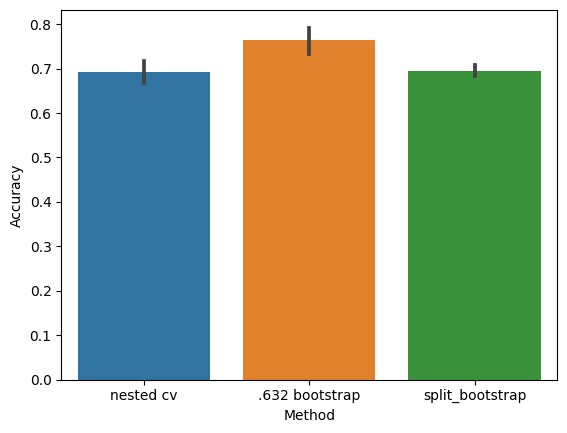

In [54]:
sns.barplot(x='Method', y='Accuracy', data=df, errorbar='ci')

<AxesSubplot:xlabel='Method', ylabel='AUC'>

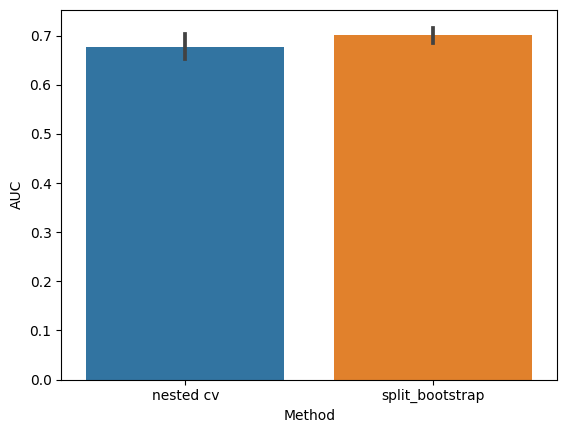

In [55]:
sns.barplot(x='Method', y='AUC', data=df[df.Method != '.632 bootstrap'], errorbar='ci')